# Spin dynamics

In [74]:
## imports
 
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.constants import *

## System described here

We want to describe our system as it will be at first on the benchtop version.
We have the laser and the rf field $B_1$ along the z axis, the field to measure $B_0$ in the  xy-plane (according to [1]).

$$ \partial_t \begin{pmatrix} S_x \\ S_y \\ S_z \end{pmatrix} = \begin{pmatrix} S_x \\ S_y \\ S_z \end{pmatrix} \wedge \begin{pmatrix} \gamma B_0 \cos(\theta) \\ \gamma B_0 \sin(\theta) \\ \gamma B_{rf}\cos(\omega_{rf} t) \end{pmatrix} - \Gamma \begin{pmatrix} S_x \\ S_y \\ S_z \end{pmatrix} + R_{op} \begin{pmatrix}- S_x \\ - S_y \\ S_0-M_z\end{pmatrix} $$


$$
\partial_t \begin{pmatrix} S_x \\ S_y \\ S_z \end{pmatrix} =
\begin{pmatrix} 
\gamma B_{rf} \cos(\omega_{rf} t) S_y - \gamma B_0\sin(\theta) S_z  \\ 
\gamma B_0 \cos(\theta) S_z - \gamma B_{rf} \cos(\omega_{rf} t) S_x  \\ 
\gamma B_0 \sin(\theta) S_x - \gamma B_0 \cos(\theta) S_y 
\end{pmatrix}
- \Gamma \begin{pmatrix} S_x \\ S_y \\ S_z \end{pmatrix}
+ R_{op} \begin{pmatrix} - S_x \\ - S_y \\ S_0 - S_z \end{pmatrix}.
$$


In [75]:
## Constants
gamma = 7e9    # Gyromagnetic ratio (Hz/T)
sigma = 1.082e-13 #m^2 from Table 7, [2]
mu_B = 9.2740100657e-24 # J/T Bohr Magneton

## Parameters
Gamma = 2000    # Relaxation rate (Hz)
R_op = 3.07e7*0.1*0.5   # Optical pumping rate (Hz)

B_0 = 100e-9    # Static field intensity (Tesla)
B_1 = 1e-4      # RF field intensity (Tesla)
theta = 60*np.pi/180

P_laser = 0.2e-3 # Laser power (W)
beam_diameter = 1e-3 # self-explanatory (m)

P = 3e-1        # Cell pressure (Pa)
V = 3e-3*3e-3*1.9e-3 # Cell volume (m^3)
z_cell = 1.9e-2 # Cell length (m)
T = 273.15+60   # Cell temperature (K)

## Derived parameters
omega = gamma * B_0   # Frequency of the RF field (Hz)
I_0 = P_laser/(np.pi*(beam_diameter/2)**2) # Laser intensity before the cell (W/m²)
n = P/(k*T)     # Rb density (m^-3)
N = P*V/(k*T) # Number of particles
S_0 = 1      # maximum magnetization


$$
\partial_t \begin{pmatrix} S_x \\ S_y \\ S_z \end{pmatrix} =
\begin{pmatrix} 
\gamma B_{rf} \cos(\omega_{rf} t) S_y - \gamma B_0\sin(\theta) S_z  \\ 
\gamma B_0 \cos(\theta) S_z - \gamma B_{rf} \cos(\omega_{rf} t) S_x  \\ 
\gamma B_0 \sin(\theta) S_x - \gamma B_0 \cos(\theta) S_y 
\end{pmatrix}
- \Gamma \begin{pmatrix} S_x \\ S_y \\ S_z \end{pmatrix}
+ R_{op} \begin{pmatrix} - S_x \\ - S_y \\ S_0 - S_z \end{pmatrix}.
$$


In [76]:
def bloch_equations(t, S, gamma, B_0, B_1, omega, Gamma, R_op, S_0):
    Sx, Sy, Sz = S
    cos_omega_t = np.cos(omega * t)
    term1 = B_1 * cos_omega_t
    term2 = B_0 * np.cos(theta)
    term3 = B_0 * np.sin(theta)

    dSxdt = gamma * term1 * Sy - gamma * term3 * Sz - (Gamma + R_op) *Sx
    dSydt = gamma * term2 * Sz - gamma * term1 *Sx - (Gamma + R_op) * Sy
    dSzdt = gamma * term3 *Sx - gamma * term2 * Sy - (Gamma) * Sz + R_op * (S_0 - Sz)
    return [dSxdt, dSydt, dSzdt]

def solve_bloch_equations(initial_state, t_span, t_eval, gamma, B_0, B_1, omega, Gamma, R_op, S_0):
    solution = solve_ivp(
        bloch_equations,
        t_span,
        initial_state,
        method='BDF',  
        t_eval=t_eval,
        args=(gamma, B_0, B_1, omega, Gamma, R_op, S_0)
    )
    return solution

initial_state = [0, 0, 0]
t_span = [0, 10]
sampling_rate = 1000000
t_eval = np.linspace(t_span[0], t_span[1], sampling_rate)  

solution = solve_bloch_equations(initial_state, t_span, t_eval, gamma = gamma, B_0 = B_0, B_1 = B_1, omega = omega, Gamma = Gamma, R_op = R_op, S_0=S_0)

t = solution.t
Sx, Sy, Sz = solution.y

print(f"FinalSx: {Sx[-1]:.4f}")
print(f"Final Sy: {Sy[-1]:.4f}")
print(f"Final Sz: {Sz[-1]:.4f}")

FinalSx: -0.0003
Final Sy: 0.0003
Final Sz: 0.9987


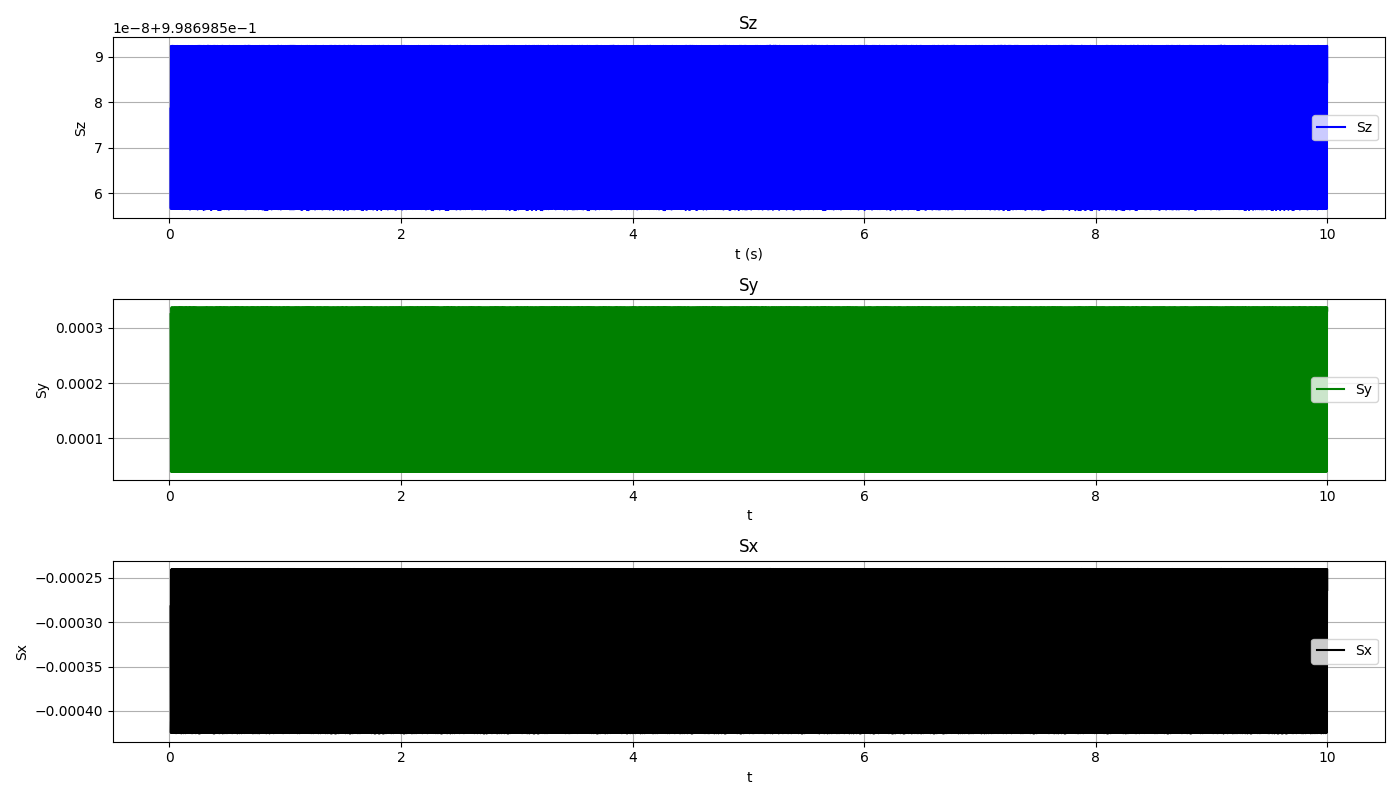

In [ ]:
%matplotlib widget
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 8))

points_to_skip = 1000

axes[0].plot(t[points_to_skip:], Sz[points_to_skip:], color='blue', label='Sz')
axes[0].set_title('Sz')
axes[0].set_xlabel('t (s)')
axes[0].set_ylabel('Sz')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(t[points_to_skip:], Sy[points_to_skip:], color='green', label='Sy')
axes[1].set_title('Sy')
axes[1].set_xlabel('t')
axes[1].set_ylabel('Sy')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(t[points_to_skip:],Sx[points_to_skip:], color='black', label='Sx')
axes[2].set_title('Sx')
axes[2].set_xlabel('t')
axes[2].set_ylabel('Sx')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()

plt.show()

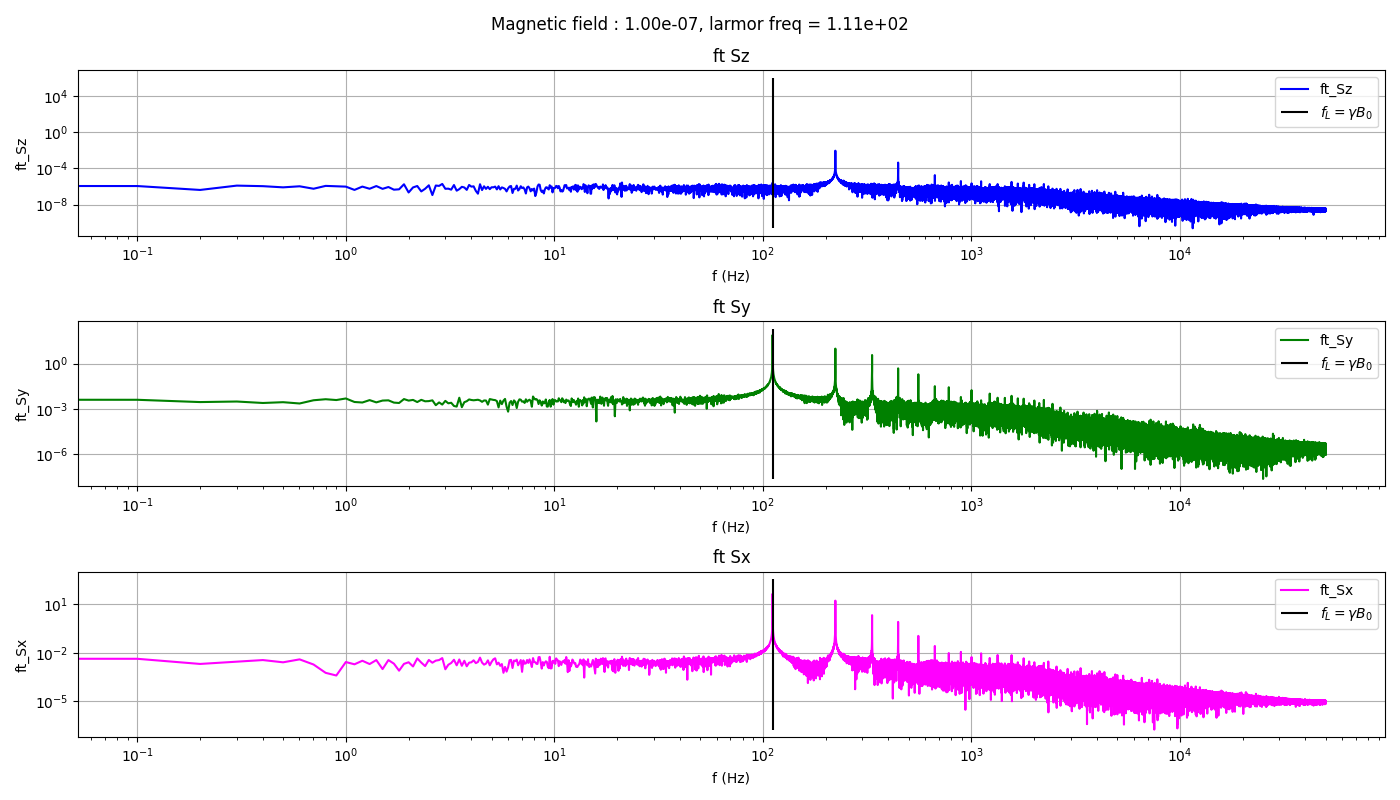

In [ ]:
dt = t_eval[1]-t_eval[0]
freq = np.fft.rfftfreq(len(t_eval[points_to_skip:]), d=dt)
#freq_shifted = np.abs(np.fft.fftshift(freq))

ft_Sz = np.abs(np.fft.rfft(Sz[points_to_skip:]))
ft_Sy = np.abs(np.fft.rfft(Sy[points_to_skip:]))
ft_Sx = np.abs(np.fft.rfft(Sx[points_to_skip:]))

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 8))

fig.suptitle('Magnetic field : {:.2e}, larmor freq = {:.2e}'.format(B_0, gamma*B_0/(2*np.pi)))

axes[0].plot(freq, ft_Sz, color='blue', label='ft_Sz')
axes[0].vlines(gamma*B_0/(2*np.pi), min(ft_Sz), max(ft_Sz), color = 'k', label='$f_{L} = \gamma B_0 $')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_title('ft Sz')
axes[0].set_xlabel('f (Hz)')
axes[0].set_ylabel('ft_Sz')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(freq, ft_Sy, color='green', label='ft_Sy')
axes[1].vlines(gamma*B_0/(2*np.pi), min(ft_Sy), max(ft_Sy), color = 'k', label='$f_{L} = \gamma B_0 $')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_title('ft Sy')
axes[1].set_xlabel('f (Hz)')
axes[1].set_ylabel('ft_Sy')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(freq, ft_Sx, color='magenta', label='ft_Sx')
axes[2].vlines(gamma*B_0/(2*np.pi), min(ft_Sx), max(ft_Sx), color = 'k', label='$f_{L} = \gamma B_0 $')
axes[2].set_xscale('log')
axes[2].set_yscale('log')
axes[2].set_title('ft Sx')
axes[2].set_xlabel('f (Hz)')
axes[2].set_ylabel('ft_Sx')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()

plt.show()

## Discussions

The factor 2 between the frequency observed in $M_z$ and the Larmor frequency remains unexplained. 
The simulation seems believable otherwise.

# Light absorption of the system

## Equations and system described


In [3] is given the differential equation for the light intensity across the vapour cell :

$$\partial_z I(z) = -n \sigma(\nu) I(z) (1-sM_z)$$
Where : 
- n is the density of alkali-metal atoms; $n = \frac{1}{T}10^{21.866+A - \tfrac{B}{T}}$
- $\sigma(\nu)$ is the photon absorption cross section
- s is the photon polarization
- $M_z$ is the magnetization on the z-axis 

Yet they use a balanced photodetector. We will assume that the $1-M_z$ comes from there.<br>
Adjusting to ourcase, we believe to be in the following situation :
$$\partial_z I(z) = -n \sigma(\nu) I(z) M_z$$
solution being:
$$I(z,t) = I(0,t) e^{- \left(n\sigma M_z(t) z \right)}$$

We take $M_z = n g\mu_b S_z$, but this quantity must be unitless to fit in the expression above. NEED HELP THERE

Problem is that it wouldn't be senseless to me to use the spin directly, i.e. value between -1 and 1. Nevertheless, it would mean that for Rb, i could be only in a very short range of density, which doesn't make sense to me according to what CSEM says, but also what is done. I refuse to believe that above 1e-12 m^-1, we have full absorption for Rb.

In [79]:
def absorption_equation(z, I_0, sigma, n, Mz):
    I = I_0 * np.exp(-n*sigma*(Mz)*z)
    return I

Mz = n * mu_B * Sz

I_z_t = np.zeros(len(Sz))
test = np.zeros(len(Sz))

for i, Mz_t in enumerate(Mz):
    I_z_t[i] = absorption_equation(z = z_cell, I_0 = I_0, sigma = sigma, n=n, Mz= Mz_t)
    test[i] = -n*sigma*(Mz_t)*z_cell

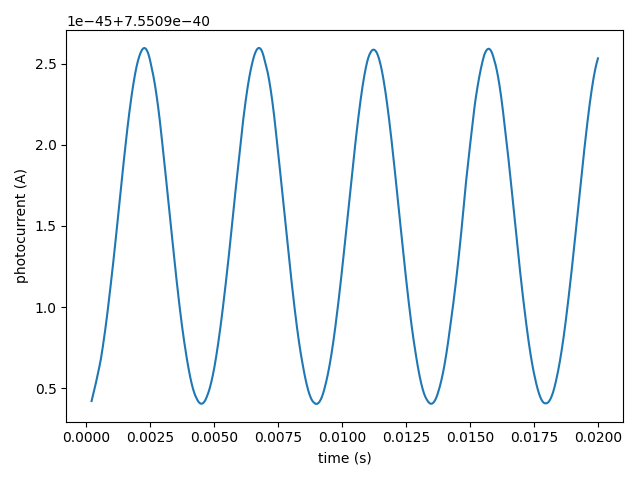

In [81]:
R = 0.568 #A/W, for standard thorlabs Si photodiode

P_z_t = I_z_t * (np.pi*(beam_diameter/2)**2)
photocurrent_z_t = R*P_z_t

fig,axes=plt.subplots()
axes.plot(t[20:2000],photocurrent_z_t[20:2000])
axes.set_xlabel('time (s)')
axes.set_ylabel('photocurrent (A)')
plt.tight_layout()
plt.show()

# Additional part to point out that something feels wrong there.
<br>
I have N_photons in my system per second, and i have 2N/5 Rb atoms. if we assume a relaxation rate of 2000 (which is pretty low), we have more Rb atoms available per second than photons per second, which corroborate the simulation showing a total absorption. Nevertheless, CSEM's cells have a much higher relaxation rate, higher number of atoms, same laser power and still observe transmitted light. Something is off in what i'm currently doing, but i'm having a hard time finding what. 

In [94]:
P = 0.2e-3
N = n*V
N_photon = P*795e-9/(h*c)
print('N_photon = {:.2E}'.format(N_photon))

N_photon = 8.00E+14


In [ ]:
print('N = {:.2E}'.format(2/5*N))

N = 8.92E+14


# Sources



[1] : 'How to build a magnetometer with thermal atomic vapor: a tutorial', A. Fabricant, I. Novikova, G. Bison. <br>
[2] : 'Rubidium 87 D Line Data', Daniel A. Steck <br>
[3] : "In-situ measurement and close-loop control of atomic number density in an optically pumped magnetometer based on light absorption", ZiaoLiu et al 2023